# Tangles-CNN Training Notebook

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


## Model Setup
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
# exp_dir = "/home/me/data/patches/exp01"
exp_dir = "/home/pyushkevich/data/neurons/patches/exp02_gran"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
config = {
    "num_classes": 2,
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 4,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 16
    }
}

## Model instantiation and training

In [3]:
# Instantiate WildCat model
data_dir = os.path.join(exp_dir, "patches")
model=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

In [4]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-2)

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=config['wildcat_upsample']['batch_size'], 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

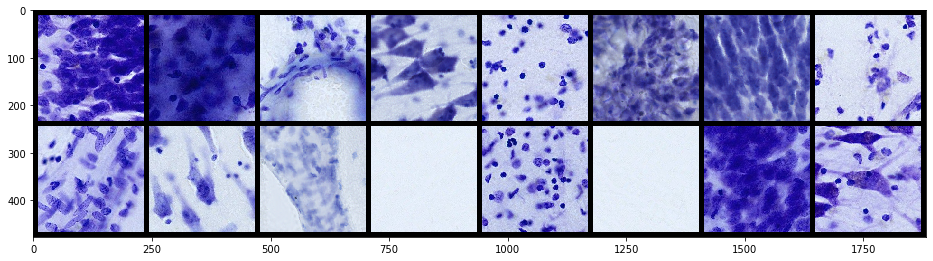

In [5]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

In [6]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [7]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [8]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])

Epoch 0/29
----------


/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train Loss: 0.2751 Acc: 0.8814
val Loss: 0.1867 Acc: 0.9269

Epoch 1/29
----------
train Loss: 0.1259 Acc: 0.9653
val Loss: 0.1154 Acc: 0.9683

Epoch 2/29
----------
train Loss: 0.1077 Acc: 0.9719
val Loss: 0.1348 Acc: 0.9489

Epoch 3/29
----------
train Loss: 0.1003 Acc: 0.9745
val Loss: 0.0938 Acc: 0.9727

Epoch 4/29
----------
train Loss: 0.0873 Acc: 0.9750
val Loss: 0.0533 Acc: 0.9894

Epoch 5/29
----------
train Loss: 0.0906 Acc: 0.9763
val Loss: 0.1627 Acc: 0.9507

Epoch 6/29
----------
train Loss: 0.0706 Acc: 0.9829
val Loss: 0.0501 Acc: 0.9912

Epoch 9/29
----------
train Loss: 0.0737 Acc: 0.9833
val Loss: 0.0556 Acc: 0.9850

Epoch 10/29
----------
train Loss: 0.0599 Acc: 0.9868
val Loss: 0.0437 Acc: 0.9894

Epoch 11/29
----------
train Loss: 0.0759 Acc: 0.9811
val Loss: 0.0779 Acc: 0.9780

Epoch 12/29
----------
train Loss: 0.0499 Acc: 0.9895
val Loss: 0.1006 Acc: 0.9806

Epoch 13/29
----------
train Loss: 0.0606 Acc: 0.9855
val Loss: 0.1801 Acc: 0.9436

Epoch 14/29
----------

## Export model

In [18]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.state_dict(), os.path.join(model_dir, "wildcat_upsample.dat"))

# Save the configuration
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

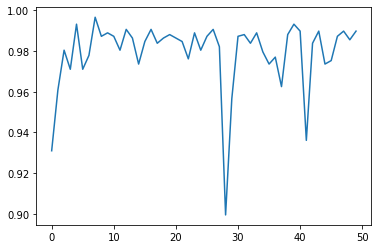

In [11]:
plt.plot(hist)

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Mon Dec 14 16:12:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    49W / 250W |   2079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------